In [54]:
!pip install lime

In [55]:
!pip install tsmoothie

In [56]:
!pip install altair

# Import Libraries

In [57]:
%matplotlib inline

import bz2
import json
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

from collections import Counter
from lime.lime_text import LimeTextExplainer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.pipeline import make_pipeline
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from tsmoothie.utils_func import sim_randomwalk
from tsmoothie.smoother import ConvolutionSmoother, ExponentialSmoother, LowessSmoother
from tsmoothie.bootstrap import BootstrappingWrapper
import datetime
from datetime import datetime
import altair as alt
from bs4 import BeautifulSoup
import requests
import re
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, StratifiedKFold

In [58]:
RANDOM_SEED = 655

# Importing Celtics Text Data Previously Extracted from Twitter

In [59]:
tweets_df_Celtics = pd.read_csv('tweets_df_Celtics.csv')
tweets_df_Celtics.head()

,Unnamed: 0,user_name,user_location,user_description,user_verified,date,text,hashtags,source
0,0,The Celtics Files,"Boston, MA",Opening the files on all things Celtics 🍀,False,2022-10-11 15:06:01+00:00,"Think of it like this. After the weekend, ther...",['Celtics'],Twitter for iPhone
1,1,Maillot de Foot Pas Cher,COMMANDER➩,Prix: 15€\n✈📦 Expedition : Express 8/10 jours,False,2022-10-11 15:05:56+00:00,⚽|Nouveau #Celtics Vert 2022 Jayson Tatum 0⃣\n...,"['Celtics', 'playoffnba']",TweetDeck
2,2,Boston Celtics Fans,NaN,Boston Celtics Fan Page. NOT linked to Officia...,False,2022-10-11 14:55:04+00:00,Jayson Tatum surprises fans on stage at Jack H...,"['Boston', 'TeamCeltics', 'Celtics', 'CelticsT...",SocialBee.io v2
3,3,The Celtics Files,"Boston, MA",Opening the files on all things Celtics 🍀,False,2022-10-11 14:54:43+00:00,Grant Williams took an enormous leap last year...,NaN,Twitter for iPhone
4,4,Boston Celtics Fans,NaN,Boston Celtics Fan Page. NOT linked to Officia...,False,2022-10-11 14:51:01+00:00,Celtics sign A.J. Reeves to Exhibit 10 contrac...,"['Boston', 'TeamCeltics', 'Celtics', 'CelticsT...",SocialBee.io v2


In [60]:
Celtics_tweet_text = tweets_df_Celtics['text']
Celtics_text_source = tweets_df_Celtics['source']
d = {'Celtics_Tweet_Text':Celtics_tweet_text, 'Celtics_Text_Source':Celtics_text_source}
Celtics_tweet_df = pd.DataFrame(data=d)
Celtics_tweet_df.head()

,Celtics_Tweet_Text,Celtics_Text_Source
0,"Think of it like this. After the weekend, ther...",Twitter for iPhone
1,⚽|Nouveau #Celtics Vert 2022 Jayson Tatum 0⃣\n...,TweetDeck
2,Jayson Tatum surprises fans on stage at Jack H...,SocialBee.io v2
3,Grant Williams took an enormous leap last year...,Twitter for iPhone
4,Celtics sign A.J. Reeves to Exhibit 10 contrac...,SocialBee.io v2


# Cleaning the data

In [61]:
Celtics_tweet_df['Celtics_Tweet_Text'] = Celtics_tweet_df['Celtics_Tweet_Text'].apply(lambda x: x.lower())

In [62]:
Celtics_tweet_df['Celtics_Tweet_Text'] = Celtics_tweet_df['Celtics_Tweet_Text'].apply(lambda x: BeautifulSoup(x, 'html.parser').get_text())
Celtics_tweet_df['Celtics_Tweet_Text'] = Celtics_tweet_df['Celtics_Tweet_Text'].apply(lambda x: ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", x).split()))

In [63]:
Celtics_tweet_df.head()

,Celtics_Tweet_Text,Celtics_Text_Source
0,think of it like this after the weekend there ...,Twitter for iPhone
1,nouveau celtics vert 2022 jayson tatum 0 au pr...,TweetDeck
2,jayson tatum surprises fans on stage at jack h...,SocialBee.io v2
3,grant williams took an enormous leap last year...,Twitter for iPhone
4,celtics sign a j reeves to exhibit 10 contract...,SocialBee.io v2


# Split the Data with Train-Test-Split

In [64]:
train_df, dev_df, test_df = np.split(Celtics_tweet_df.sample(frac=1, random_state=655),
                                    [int(.8*len(Celtics_tweet_df)), int(.9*len(Celtics_tweet_df))])

train_df, dev_df, test_df

(                                     Celtics_Tweet_Text Celtics_Text_Source
 621   celtics look really tired mazzulla calls timeo...           TweetDeck
 2253  what can sam hauser and luke kornet give the b...     SocialBee.io v2
 1359  the raptors will be without otto porter jr lef...     SocialBee.io v2
 1373  the nbapreseason continues who are your picks ...      Hootsuite Inc.
 1342  time lord the grifster banner18 celtics boston...  Twitter for iPhone
 ...                                                 ...                 ...
 922   malcolm brogdon nba highlights celtics vs rapt...     Twitter Web App
 5061  preseason game three c s have split their firs...  Twitter for iPhone
 1643  after an offseason tinkering with his shot der...  Twitter for iPhone
 79    after drama filled stops in los angeles and br...     SocialBee.io v2
 1470  nba gm survey celtics receive 4th most votes t...         CelticsPlow
 
 [4836 rows x 2 columns],
                                      Celtics_Tw

# Convert the training/test corpus to TFIDF feature vectors

In [65]:
bigram_vectorizer = TfidfVectorizer(min_df=100, stop_words='english', ngram_range=(1,2))
X_train = bigram_vectorizer.fit_transform(train_df.Celtics_Tweet_Text)
X_dev = bigram_vectorizer.transform(dev_df.Celtics_Tweet_Text)
X_test = bigram_vectorizer.transform(test_df.Celtics_Tweet_Text)
y_train = list(train_df.Celtics_Text_Source)
y_dev = list(dev_df.Celtics_Text_Source)
y_test = list(test_df.Celtics_Text_Source)
X_train.shape
X_train, X_dev, X_test, y_train, y_dev, y_test

(<4836x96 sparse matrix of type '<class 'numpy.float64'>'
 	with 34406 stored elements in Compressed Sparse Row format>,
 <604x96 sparse matrix of type '<class 'numpy.float64'>'
 	with 4303 stored elements in Compressed Sparse Row format>,
 <605x96 sparse matrix of type '<class 'numpy.float64'>'
 	with 4158 stored elements in Compressed Sparse Row format>,
 ['TweetDeck',
  'SocialBee.io v2',
  'SocialBee.io v2',
  'Hootsuite Inc.',
  'Twitter for iPhone',
  'SocialBee.io v2',
  'Twitter Web App',
  'SocialBee.io v2',
  'Twitter for iPhone',
  'SocialBee.io v2',
  'Twitter for Advertisers',
  'Twitter for iPhone',
  'Twitter for iPhone',
  'SocialBee.io v2',
  'Twitter for iPhone',
  'Twitter for iPhone',
  'SocialBee.io v2',
  'Twitter for Android',
  'SocialBee.io v2',
  'Twitter for iPhone',
  'Twitter for iPhone',
  'SocialBee.io v2',
  'SocialBee.io v2',
  'Twitter for iPhone',
  'SocialBee.io v2',
  'SocialBee.io v2',
  'Twitter for iPhone',
  'SocialBee.io v2',
  'SocialBee.io v2

# Check the Shape of the training/test data

In [66]:
X_train.shape

(4836, 96)

In [67]:
X_dev.shape

(604, 96)

In [68]:
X_test.shape

(605, 96)

# Check the label count for the training data

In [69]:
label_count = Counter(y_train)
label_count

Counter({'TweetDeck': 211,
         'SocialBee.io v2': 1770,
         'Hootsuite Inc.': 11,
         'Twitter for iPhone': 1225,
         'Twitter Web App': 632,
         'Twitter for Advertisers': 3,
         'Twitter for Android': 339,
         'love.nba': 191,
         'chart bot2': 5,
         'Instagram': 7,
         'RetroSeasons Boston': 13,
         'WordPress.com': 70,
         'Twitter for iPad': 23,
         'CKBot': 29,
         'HatCrawler': 13,
         'Adventure Machine': 6,
         'Zoho Social': 10,
         'Talon Android': 2,
         'raw-chili': 50,
         'Crowdfire App': 6,
         'THEDOTBEST': 27,
         'CelticsPlow': 10,
         'Blog2Social APP': 8,
         'Newsoneplace To Twitter': 4,
         'Twitter Media Studio': 27,
         'Spreaker': 14,
         'BestTLDApp': 28,
         'Buffer': 13,
         'SocialFlow': 6,
         'TalkBasket': 13,
         'Plume\xa0for\xa0Android': 2,
         'Poshmark': 3,
         'SocialNewsDesk': 11,
        

# Hyperparameter tuning using GridSearchCv

In [70]:
# A list of parameters of the first classifier is listed to allow observation of what parameters could be specified and
# diagnosed during gridsearch

# Look at parameters used by our current LR
RFC = RandomForestClassifier()
print('Parameters currently in use:\n')
print(RFC.get_params())

Parameters currently in use:

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [71]:
#create a cross-validation scheme
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

#X_train_fs, X_test_fs, fs = select_features(X_train_scaled, y_train, X_test)

## identify parameters
param_grid = {'bootstrap' : [True], 
              'max_depth' : [1,2,3,4], 
              'max_features' : [1,2,3,4],
              'min_samples_split' : [1,2,3,4],
              'n_estimators': [25, 50, 75, 100, 125, 150, 175, 200]}  

# perform grid search
# specify model
RFC = RandomForestClassifier()
grid_searcher = GridSearchCV(estimator=RFC, param_grid=param_grid, cv=folds, n_jobs=-1, verbose=2)
grid_searcher.fit(X_train, y_train)

Fitting 5 folds for each of 512 candidates, totalling 2560 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 2560 out of 2560 | elapsed:  5.9min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [1, 2, 3, 4],
                         'max_features': [1, 2, 3, 4],
                         'min_samples_split': [1, 2, 3, 4],
                         'n_estimators': [25, 50, 75, 100, 125, 150, 175, 200]},
             verbose=2)

In [72]:
# After running GridSearchCV, the best_params_ parameter was called to identify the recommended parameter setup

best_grid = grid_searcher.best_params_
best_grid

{'bootstrap': True,
 'max_depth': 4,
 'max_features': 4,
 'min_samples_split': 3,
 'n_estimators': 150}

In [73]:
# Logistic Regression parameters were identified

# Look at parameters used by our current forest
LR = LogisticRegression()
print('Parameters currently in use:\n')
print(LR.get_params())

Parameters currently in use:

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


In [74]:
#create a cross-validation scheme
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

# identify parameters
param_grid = {'penalty': ['l2', 'none', 'elasticnet'], 
            'l1_ratio' : [0,1], 
            'solver': ['lbfgs', 'liblinear', 'sag', 'saga'],
             'random_state':[0,42],
             'max_iter':[50,75,100,125,150,175,200,225,250,275,300]} 

# perform grid search
# specify model
LR = LogisticRegression()
grid_searcher1 = GridSearchCV(estimator=LR, param_grid=param_grid, cv=folds)
grid_searcher1.fit(X_train, y_train)

C:\Users\tjame\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\Users\tjame\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\tjame\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:

GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=LogisticRegression(),
             param_grid={'l1_ratio': [0, 1],
                         'max_iter': [50, 75, 100, 125, 150, 175, 200, 225, 250,
                                      275, 300],
                         'penalty': ['l2', 'none', 'elasticnet'],
                         'random_state': [0, 42],
                         'solver': ['lbfgs', 'liblinear', 'sag', 'saga']})

In [88]:
#Identifying the best parameters to utilize
best_grid1 = grid_searcher1.best_params_
best_grid1

{'l1_ratio': 0,
 'max_iter': 275,
 'penalty': 'none',
 'random_state': 0,
 'solver': 'lbfgs'}

# Train the Model

In [89]:
lr_clf = LogisticRegression(random_state=RANDOM_SEED, multi_class='auto', solver='lbfgs', l1_ratio=0, max_iter=275,
                            penalty='none')
rf_clf = RandomForestClassifier(bootstrap=True, n_estimators=150, max_depth=4, max_features=4, min_samples_split=3, 
                                random_state=RANDOM_SEED)

In [90]:
print('started fitting')
lr_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)
print('finished fitting')

started fitting


C:\Users\tjame\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\Users\tjame\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


finished fitting


# Create a Dummy Baseline for Performance Comparison

In [91]:
random_clf = DummyClassifier(strategy='uniform', random_state=RANDOM_SEED).fit(X_train, y_train)

# Evaluate the Model

In [92]:
y_pred_dev = lr_clf.predict(X_dev)
y_pred_test = lr_clf.predict(X_test)
rf_y_pred_dev = rf_clf.predict(X_dev)
rf_y_pred_test = rf_clf.predict(X_test)
random_y_pred_dev = random_clf.predict(X_dev)
random_y_pred_test = random_clf.predict(X_test)
y_pred_dev, y_pred_test, rf_y_pred_dev, rf_y_pred_test, random_y_pred_dev, random_y_pred_test

(array(['love.nba', 'HatCrawler', 'Twitter for iPhone',
        'Twitter for iPhone', 'Twitter Web App', 'SocialBee.io v2',
        'SocialBee.io v2', 'Twitter for iPhone', 'SocialBee.io v2',
        'Twitter for iPhone', 'TalkBasket', 'Twitter Web App',
        'Twitter for iPhone', 'Twitter for iPhone', 'Twitter for iPhone',
        'SocialBee.io v2', 'SocialBee.io v2', 'Sprout Social',
        'Twitter for iPhone', 'SocialBee.io v2', 'Twitter for iPhone',
        'Twitter for iPhone', 'raw-chili', 'Twitter for iPhone',
        'Twitter for iPad', 'SocialBee.io v2', 'SocialBee.io v2',
        'Twitter for Android', 'SocialBee.io v2', 'SocialBee.io v2',
        'Twitter for iPhone', 'Twitter for iPhone', 'Twitter Web App',
        'SocialBee.io v2', 'Twitter Web App', 'Twitter for iPhone',
        'Twitter for iPhone', 'Twitter for iPhone', 'Twitter for iPhone',
        'Twitter for iPhone', 'SocialBee.io v2', 'SocialBee.io v2',
        'SocialBee.io v2', 'Buffer', 'SocialBee.io v2',


# Score the Predictions

In [93]:
lr_test_f1 = f1_score(y_test, y_pred_test, average='macro')
rf_test_f1 = f1_score(y_test, rf_y_pred_test, average='macro')
rand_test_f1 = f1_score(y_test, random_y_pred_test, average='macro')
lr_dev_f1 = f1_score(y_dev, y_pred_dev, average='macro')
rf_dev_f1 = f1_score(y_dev, rf_y_pred_dev, average='macro')
rand_dev_f1 = f1_score(y_dev, random_y_pred_dev, average='macro')
lr_test_f1, rf_test_f1, rand_test_f1, lr_dev_f1, rf_dev_f1, rand_dev_f1

(0.5478754178188486,
 0.1038119640559471,
 0.00647108784104241,
 0.709466744961534,
 0.09634286761242546,
 0.00704943586486811)

# Explaining Predictions Using Lime

# Creating Explainer and Classifier Pipelines

In [94]:
LTE = LTE = LimeTextExplainer(kernel_width=10, kernel=None, verbose=False, class_names=['sarcastic','non-sarcastic'], 
                        feature_selection='auto', split_expression='\W+', bow=True, mask_string=None, 
                        random_state=RANDOM_SEED, char_level=False)
rf_pipe = make_pipeline(bigram_vectorizer, rf_clf)
lr_pipe = make_pipeline(bigram_vectorizer, lr_clf)

In [95]:
test_row_df = test_df.sample(1, random_state=RANDOM_SEED)
_, inst_text, label = next(test_row_df.itertuples())

print('Comment has text "%s"' %(inst_text))
print('True label: %s' % label)
print('LogisticRegression Probability(Sarcastic) =', lr_pipe.predict_proba([inst_text])[0, 1])
print('RandomForest Probability(Sarcastic) =', rf_pipe.predict_proba([inst_text])[0, 1])

Comment has text "love the look downtown celtics"
True label: Twitter Web App
LogisticRegression Probability(Sarcastic) = 1.1871326350986307e-17
RandomForest Probability(Sarcastic) = 0.000760673272926718


# Use the explainer object to generate predictions for each of the classifier pipelines

In [96]:
rf_explanation = LTE.explain_instance(inst_text, rf_pipe.predict_proba, num_features=10)

lr_explanation = LTE.explain_instance(inst_text, lr_pipe.predict_proba, num_features=10)
rf_explanation, lr_explanation

(<lime.explanation.Explanation at 0x12cfdd34070>,
 <lime.explanation.Explanation at 0x12c80016e80>)

# Examine the Explanations

# We will examine the amount of negative vs positive scoring-weight Lime gives to some of the keywords from the tweet text

In [112]:
for feat, val in lr_explanation.as_list():
    print('LogisticRegression has an estimated weight of %f on feature "%s"' % (val, feat))


LogisticRegression has an estimated weight of -0.000000 on feature "celtics"
LogisticRegression has an estimated weight of 0.000000 on feature "look"
LogisticRegression has an estimated weight of 0.000000 on feature "the"
LogisticRegression has an estimated weight of 0.000000 on feature "love"
LogisticRegression has an estimated weight of 0.000000 on feature "downtown"


In [113]:
for feat, val in rf_explanation.as_list():
    print('LogisticRegression has an estimated weight of %f on feature "%s"' % (val, feat))

LogisticRegression has an estimated weight of -0.000069 on feature "celtics"
LogisticRegression has an estimated weight of 0.000001 on feature "downtown"
LogisticRegression has an estimated weight of 0.000001 on feature "love"
LogisticRegression has an estimated weight of 0.000001 on feature "look"
LogisticRegression has an estimated weight of 0.000001 on feature "the"


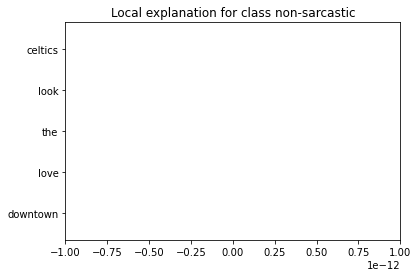

In [116]:
fig1 = lr_explanation.as_pyplot_figure()

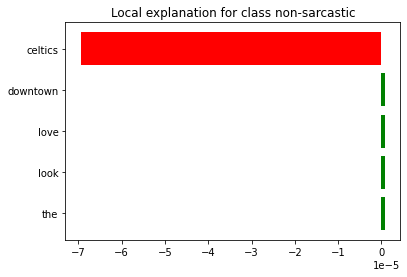

In [110]:
fig2 = rf_explanation.as_pyplot_figure()